## GridWorldEnvironment
```py
start_point = (0,0)
end_point = (4,4)
gridworld_size = (5,5)
env = GridWorldEnvironment(start_point, end_point, grid_world_size)
```

In [ ]:
%pip install numpy matplotlib seaborn torch

In [4]:
import matplotlib.pyplot as plt
import random
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
import time
from collections import deque

## Original Code

In [16]:
import numpy as np
from typing import Tuple

class GridWorldEnvironment:
    def __init__(self, start_point:Tuple, end_point:Tuple, grid_world_size:Tuple):
        # 시작점과 끝점을 받는다.
        self.start_point = start_point
        self.end_point = end_point if end_point != (-1,-1) else (grid_world_size[0] + end_point[0],
                                                                 grid_world_size[1] + end_point[1])

        # 그리드 월드의 규격을 받는다.
        self.width, self.height = grid_world_size

        # action dictionary
        self.action_space = ['up', 'down', 'left', 'right']
        self.num_actions = len(self.action_space)
        self.actions = {'up':(-1,0),
                        'down':(1,0),
                        'left':(0,-1),
                        'right':(0,1) }

        # 상태 : 좌표로 나타남
        self.traces = []

        # total states
        self.total_states = []
        for x in range(self.width):
            for y in range(self.height):
                self.total_states.append((x,y))

        # reward
        self.reward = np.zeros(shape=(self.height, self.width)).tolist()
        self.reward[end_point[0]][end_point[1]] = 1

    def render(self):
        # 그리드 월드의 상태를 출력한다.
        self.grid_world = np.full(shape=(self.height, self.width), fill_value=".").tolist()

        last_point = self.traces[-1] # 에이전트가 가장 마지막에 있었던 위치
        traces = list(set(self.traces)) # 중복된 값을 삭제하기 위함
        for trace in traces:
            self.grid_world[trace[0]][trace[1]] = "X"

        self.grid_world[self.start_point[0]][self.start_point[1]] = "S" # start point
        self.grid_world[self.end_point[0]][self.end_point[1]] = "G" # end point
        self.grid_world[last_point[0]][last_point[1]] = "A" # 현재 에이전트의 위치

        # string으로 출력한다.
        grid = ""

        for i in range(self.height):
            for j in range(self.width):
                grid += self.grid_world[i][j]+" "
            grid += "\n"

        print(grid)

    def get_reward(self, state, action_idx):
        next_state = self.state_after_action(state, action_idx)
        return self.reward[next_state[0]][next_state[1]]

    def state_after_action(self, state, action_idx:int):
        action = self.action_space[action_idx]
        row_movement, col_movement = self.actions[action]

        # action에 따라 에이전트 이동
        next_state = (state[0]+row_movement, state[1]+col_movement)
        next_state = self.check_boundary(next_state)

        return next_state

    def check_boundary(self, state):
        state = list(state)
        state[0] = (0 if state[0] < 0 else self.height - 1 if state[0] > self.height - 1 else state[0])
        state[1] = (0 if state[1] < 0 else self.width - 1 if state[1] > self.width - 1 else state[1])
        return tuple(state)

### 그리드월드 상속 및 오버라이딩

In [ ]:
class MyGridWorldEnvironment(GridWorldEnvironment):
    def __init__(self, start_point, end_point, grid_world_size):
        super().__init__(start_point, end_point, grid_world_size)
        # 시작 위치를 traces에 추가하여 초기화
        self.traces = [start_point]
    
    def render(self):
        # 그리드 월드의 상태를 출력
        self.grid_world = np.full(shape=(self.height, self.width), fill_value=".").tolist()
        
        if self.traces:  # traces가 비어있지 않은 경우에만 처리
            last_point = self.traces[-1]  # 에이전트가 마지막으로 있었던 위치
            traces = list(set(self.traces))  # 중복된 값을 삭제
            
            # 에이전트의 경로 표시
            for trace in traces:
                self.grid_world[trace[0]][trace[1]] = "X"
            
            # 현재 에이전트 위치 표시
            self.grid_world[last_point[0]][last_point[1]] = "A"
        
        # 시작점과 목표점 표시
        self.grid_world[self.start_point[0]][self.start_point[1]] = "S"
        self.grid_world[self.end_point[0]][self.end_point[1]] = "G"
        
        # 그리드를 문자열로 변환하여 출력
        grid = ""
        for i in range(self.height):
            for j in range(self.width):
                grid += self.grid_world[i][j] + " "
            grid += "\n"
        
        print(grid)
    
    def move(self, action_idx):
        """에이전트를 이동하고 보상을 반환하는 함수"""
        current_state = self.traces[-1] if self.traces else self.start_point
        
        next_state = self.state_after_action(current_state, action_idx)
        reward = self.get_reward(current_state, action_idx)
        
        # 이동 기록 저장
        self.traces.append(next_state)
        
        return next_state, reward
    
    def reset(self):
        """환경 초기화 함수: 에이전트를 시작점으로 돌려놓음"""
        self.traces = [self.start_point]
        return self.start_point

# Deep SARSA Class

In [32]:
# 신경망 모델 정의
class QNetwork(nn.Module):
    def __init__(self, state_size, action_size, hidden_size=64):
        super(QNetwork, self).__init__()
        self.fc1 = nn.Linear(state_size, hidden_size)
        self.fc2 = nn.Linear(hidden_size, hidden_size)
        self.fc3 = nn.Linear(hidden_size, action_size)
        
    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return self.fc3(x)

In [33]:
class DeepSARSA:
    def __init__(self, env, state_size=2, action_size=4, hidden_size=64, 
                 learning_rate=0.0005, gamma=0.99, epsilon=0.3, epsilon_decay=0.995, 
                 epsilon_min=0.01):
        self.env = env
        self.state_size = state_size
        self.action_size = action_size
        
        # 주 네트워크와 타겟 네트워크 구성
        self.model = QNetwork(state_size, action_size, hidden_size)
        self.target_model = QNetwork(state_size, action_size, hidden_size)
        self.update_target_model()  # 타겟 모델 초기 동기화
        
        self.optimizer = optim.Adam(self.model.parameters(), lr=learning_rate)
        self.criterion = nn.MSELoss()
        
        # 하이퍼파라미터
        self.gamma = gamma
        self.epsilon = epsilon
        self.epsilon_decay = epsilon_decay
        self.epsilon_min = epsilon_min
        self.target_update_freq = 10  # 타겟 네트워크 업데이트 주기
        
        # 경험 리플레이 메모리
        self.memory = deque(maxlen=2000)
        self.batch_size = 32
        
        # 디버깅 정보
        self.losses = []
    
    def update_target_model(self):
        """타겟 네트워크 업데이트"""
        self.target_model.load_state_dict(self.model.state_dict())
    
    def _state_to_tensor(self, state):
        return torch.FloatTensor(state).view(1, -1)
    
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            return random.randint(0, self.action_size - 1)
        else:
            with torch.no_grad():
                state_tensor = self._state_to_tensor(state)
                q_values = self.model(state_tensor)
                return torch.argmax(q_values).item()
    
    def remember(self, state, action, reward, next_state, next_action):
        """경험 저장"""
        self.memory.append((state, action, reward, next_state, next_action))
    
    def replay(self):
        """경험 리플레이로 학습"""
        if len(self.memory) < self.batch_size:
            return
        
        # 미니배치 준비
        minibatch = random.sample(self.memory, self.batch_size)
        losses = []
        
        for state, action, reward, next_state, next_action in minibatch:
            state_tensor = self._state_to_tensor(state)
            next_state_tensor = self._state_to_tensor(next_state)
            
            # 현재 Q 값
            self.optimizer.zero_grad()
            q_values = self.model(state_tensor)
            current_q = q_values[0][action]
            
            # 다음 Q 값 (SARSA는 다음 상태와 다음 행동으로 계산)
            with torch.no_grad():
                next_q_values = self.target_model(next_state_tensor)
                next_q = next_q_values[0][next_action]
            
            # TD 타겟 - 보상 스케일링 추가
            scaled_reward = reward * 0.1  # 보상 크기 조정
            target_q = scaled_reward + self.gamma * next_q
            
            # 손실 계산 및 역전파
            loss = self.criterion(current_q.unsqueeze(0), torch.tensor([target_q]))
            loss.backward()
            
            # 그래디언트 클리핑 추가
            torch.nn.utils.clip_grad_norm_(self.model.parameters(), 1.0)
            
            self.optimizer.step()
            losses.append(loss.item())
        
        # 손실 기록
        if losses:
            self.losses.append(np.mean(losses))
            
        return np.mean(losses) if losses else 0
    
    def train(self, num_episodes=300, max_steps=100):
        step_counts = []
        
        for episode in range(num_episodes):
            state = self.env.reset()
            action = self.get_action(state)
            
            steps = 0
            total_reward = 0
            episode_loss = 0
            
            while steps < max_steps:
                next_state, reward = self.env.move(action)
                total_reward += reward
                
                next_action = self.get_action(next_state)
                
                # 경험 저장
                self.remember(state, action, reward, next_state, next_action)
                
                # 경험 리플레이로 학습
                if len(self.memory) >= self.batch_size:
                    loss = self.replay()
                    episode_loss += loss
                
                state = next_state
                action = next_action
                
                steps += 1
                
                if state == self.env.end_point:
                    break
            
            # 타겟 네트워크 주기적 업데이트
            if episode % self.target_update_freq == 0:
                self.update_target_model()
            
            step_counts.append(steps)
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            
            if episode % 20 == 0:
                print(f"Episode {episode+1}/{num_episodes}, Steps: {steps}, "
                      f"Total Reward: {total_reward:.2f}, Epsilon: {self.epsilon:.3f}, "
                      f"Avg Loss: {episode_loss/steps if steps > 0 else 0:.4f}")
        
        return step_counts, self.losses

## Main

- **Deep SARSA**를 이용해 그리드 월드 학습시키기  
- 학습 지표 시각화 (에피소드마다 에이전트의 이동 횟수 시각화)

Starting Deep SARSA learning...
Episode 1/300, Steps: 150, Total Reward: 0.00, Epsilon: 0.298, Avg Loss: 0.0298
Episode 21/300, Steps: 59, Total Reward: 1.00, Epsilon: 0.270, Avg Loss: 0.0154
Episode 41/300, Steps: 10, Total Reward: 1.00, Epsilon: 0.244, Avg Loss: 0.0295
Episode 61/300, Steps: 11, Total Reward: 1.00, Epsilon: 0.221, Avg Loss: 0.0340
Episode 81/300, Steps: 11, Total Reward: 1.00, Epsilon: 0.200, Avg Loss: 0.1061
Episode 101/300, Steps: 12, Total Reward: 1.00, Epsilon: 0.181, Avg Loss: 0.2180
Episode 121/300, Steps: 9, Total Reward: 1.00, Epsilon: 0.164, Avg Loss: 0.6212
Episode 141/300, Steps: 8, Total Reward: 1.00, Epsilon: 0.148, Avg Loss: 1.3731
Episode 161/300, Steps: 8, Total Reward: 1.00, Epsilon: 0.134, Avg Loss: 2.0677
Episode 181/300, Steps: 15, Total Reward: 1.00, Epsilon: 0.121, Avg Loss: 2.6916
Episode 201/300, Steps: 8, Total Reward: 1.00, Epsilon: 0.110, Avg Loss: 5.4455
Episode 221/300, Steps: 8, Total Reward: 1.00, Epsilon: 0.099, Avg Loss: 4.9772
Episod

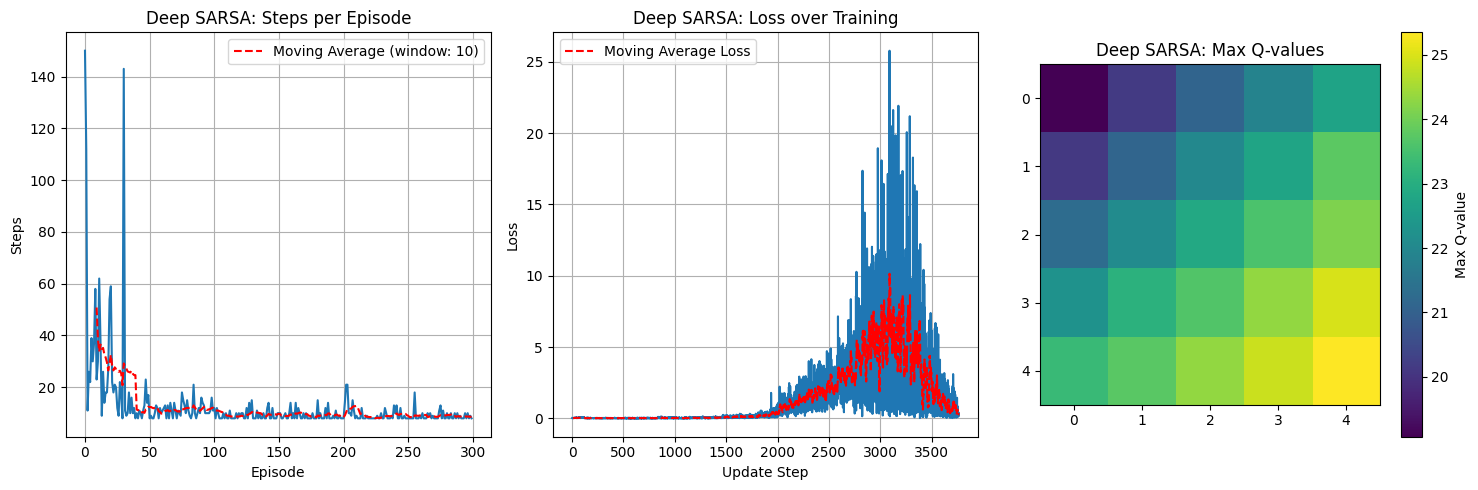


Final Learned Policy (Deep SARSA):
→ → ↓ ↓ ↓
→ ↓ ↓ ↓ ↓
→ ↓ ↓ ↓ ↓
→ ↓ ↓ ↓ ↓
→ → → → G

Agent Movement Simulation with Deep SARSA Policy:
S . . . . 
. . . . . 
. . . . . 
. . . . . 
. . . . G 

Step 1: Action=right, Reward=0.0
S A . . . 
. . . . . 
. . . . . 
. . . . . 
. . . . G 

Step 2: Action=right, Reward=0.0
S X A . . 
. . . . . 
. . . . . 
. . . . . 
. . . . G 

Step 3: Action=down, Reward=0.0
S X X . . 
. . A . . 
. . . . . 
. . . . . 
. . . . G 

Step 4: Action=down, Reward=0.0
S X X . . 
. . X . . 
. . A . . 
. . . . . 
. . . . G 

Step 5: Action=down, Reward=0.0
S X X . . 
. . X . . 
. . X . . 
. . A . . 
. . . . G 

Step 6: Action=down, Reward=0.0
S X X . . 
. . X . . 
. . X . . 
. . X . . 
. . A . G 

Step 7: Action=right, Reward=0.0
S X X . . 
. . X . . 
. . X . . 
. . X . . 
. . X A G 

Step 8: Action=right, Reward=1
S X X . . 
. . X . . 
. . X . . 
. . X . . 
. . X X G 

Goal reached! Total steps: 8


In [36]:
# Deep SARSA 메인 실행 코드
def main_deep_sarsa():
    # 환경 초기화
    env = MyGridWorldEnvironment(start_point=(0,0), 
                               end_point=(4,4), 
                               grid_world_size=(5,5))
    
    # Deep SARSA 에이전트 초기화
    agent = DeepSARSA(env, state_size=2, action_size=4, hidden_size=64,
                    learning_rate=0.001, gamma=0.99, epsilon=0.3)
    
    # 학습 시작
    print("Starting Deep SARSA learning...")
    step_counts, losses = agent.train(num_episodes=300, max_steps=150)
    print("Learning completed!")
    
    # 학습 곡선 시각화
    plt.figure(figsize=(15, 5))
    
    # 단계 수 그래프
    plt.subplot(1, 3, 1)
    plt.plot(step_counts)
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.title('Deep SARSA: Steps per Episode')
    plt.grid(True)
    
    # 이동 평균선
    window_size = 10
    if len(step_counts) > window_size:
        moving_avg = np.convolve(step_counts, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(step_counts)), moving_avg, 'r--', 
                 label=f'Moving Average (window: {window_size})')
        plt.legend()
    
    # 손실 그래프
    plt.subplot(1, 3, 2)
    plt.plot(losses)
    plt.xlabel('Update Step')
    plt.ylabel('Loss')
    plt.title('Deep SARSA: Loss over Training')
    plt.grid(True)
    
    # 이동 평균 손실
    if len(losses) > window_size:
        loss_avg = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(losses)), loss_avg, 'r--', 
                label=f'Moving Average Loss')
        plt.legend()
    
    # Q-값 시각화
    plt.subplot(1, 3, 3)
    # 그리드 월드의 각 위치에서 최대 Q-값 계산
    q_values = np.zeros((env.height, env.width))
    for i in range(env.height):
        for j in range(env.width):
            state = (i, j)
            state_tensor = torch.FloatTensor(state).view(1, -1)
            with torch.no_grad():
                q_vals = agent.model(state_tensor).numpy()[0]
                q_values[i, j] = np.max(q_vals)
    
    # 히트맵으로 표시
    plt.imshow(q_values, cmap='viridis')
    plt.colorbar(label='Max Q-value')
    plt.title('Deep SARSA: Max Q-values')
    plt.tight_layout()
    plt.show()
    
    # 최종 학습된 정책 출력
    print("\nFinal Learned Policy (Deep SARSA):")
    action_symbols = {0: "↑", 1: "↓", 2: "←", 3: "→"}
    for i in range(env.height):
        policy_row = []
        for j in range(env.width):
            if (i, j) == env.end_point:
                policy_row.append("G")
            else:
                state = (i, j)
                state_tensor = torch.FloatTensor(state).view(1, -1)
                with torch.no_grad():
                    q_vals = agent.model(state_tensor)
                    best_action = torch.argmax(q_vals).item()
                policy_row.append(action_symbols[best_action])
        print(" ".join(policy_row))
    
    # 학습된 정책으로 테스트 실행
    print("\nAgent Movement Simulation with Deep SARSA Policy:")
    state = env.reset()
    env.render()
    
    steps = 0
    max_steps = 30
    
    while state != env.end_point and steps < max_steps:
        # 탐험 없이 학습된 정책만 따름
        state_tensor = torch.FloatTensor(state).view(1, -1)
        with torch.no_grad():
            q_vals = agent.model(state_tensor)
            action = torch.argmax(q_vals).item()
        
        next_state, reward = env.move(action)
        
        print(f"Step {steps+1}: Action={env.action_space[action]}, Reward={reward}")
        env.render()
        time.sleep(0.5)  # 시각화를 위한 일시 정지
        
        state = next_state
        steps += 1
    
    # 결과 출력
    if state == env.end_point:
        print(f"Goal reached! Total steps: {steps}")
    else:
        print("Maximum steps reached.")

if __name__ == "__main__":
    main_deep_sarsa()

---

# Q-learning Class

In [23]:
# 일반 Q-learning 클래스
class QLearning:
    def __init__(self, env, learning_rate=0.1, discount_factor=0.9, epsilon=0.3, epsilon_decay=0.995, epsilon_min=0.01):
        self.env = env
        self.lr = learning_rate  # 학습률
        self.gamma = discount_factor  # 할인 계수
        self.epsilon = epsilon  # 입실론-그리디 정책의 입실론 값
        self.epsilon_decay = epsilon_decay  # 입실론 감소율
        self.epsilon_min = epsilon_min  # 최소 입실론 값
        
        # Q 테이블 초기화 (상태별, 행동별 Q값)
        self.q_table = np.random.uniform(0, 0.1, (env.height, env.width, env.num_actions))
        
        # 디버깅 정보
        self.losses = []
    
    # 입실론-그리디 정책으로 행동 선택
    def get_action(self, state):
        if np.random.rand() < self.epsilon:
            # 탐색: 무작위 행동 선택
            return random.randint(0, self.env.num_actions - 1)
        else:
            # 활용: 현재 정책에 따라 행동 선택
            row, col = state
            return np.argmax(self.q_table[row, col])
    
    # Q-learning 업데이트 규칙에 따라 Q 테이블 업데이트
    def update_q_table(self, state, action, reward, next_state):
        row, col = state
        next_row, next_col = next_state
        
        # 현재 Q 값
        current_q = self.q_table[row, col, action]
        
        # 다음 상태의 최대 Q 값 (Q-learning은 최대 Q값 사용)
        next_max_q = np.max(self.q_table[next_row, next_col])
        
        # Q-learning 업데이트 식: Q(s,a) ← Q(s,a) + α[r + γ max_a' Q(s',a') - Q(s,a)]
        td_target = reward + self.gamma * next_max_q
        td_error = td_target - current_q
        
        # Q 테이블 업데이트
        self.q_table[row, col, action] += self.lr * td_error
        
        # 손실(TD 오류) 기록
        self.losses.append(td_error ** 2)
    
    # Q-learning 알고리즘으로 학습
    def train(self, num_episodes=300, max_steps=100):
        # 에피소드별 단계 수 기록
        step_counts = []
        
        for episode in range(num_episodes):
            # 환경 초기화
            state = self.env.reset()
            
            steps = 0
            total_reward = 0
            
            # 에피소드 실행
            while steps < max_steps:
                # 현재 상태에서 행동 선택
                action = self.get_action(state)
                
                # 선택한 행동으로 다음 상태와 보상 관찰
                next_state, reward = self.env.move(action)
                total_reward += reward
                
                # Q 테이블 업데이트
                self.update_q_table(state, action, reward, next_state)
                
                # 상태 업데이트
                state = next_state
                
                steps += 1
                
                # 목표 지점에 도달하면 에피소드 종료
                if state == self.env.end_point:
                    break
            
            # 에피소드별 단계 수 기록
            step_counts.append(steps)
            
            # 입실론 감소 - 탐색에서 활용으로 점진적 전환
            self.epsilon = max(self.epsilon_min, self.epsilon * self.epsilon_decay)
            
            # 학습 과정 출력 (일부 에피소드에 대해서만)
            if episode % 20 == 0:
                print(f"Episode {episode+1}/{num_episodes}, Steps: {steps}, "
                      f"Total Reward: {total_reward:.2f}, Epsilon: {self.epsilon:.3f}")
        
        return step_counts, self.losses

## Main


- **Q-learning**를 이용해 그리드 월드 학습시키기  
- 학습 지표 시각화 (에피소드마다 에이전트의 이동 횟수 시각화)

Starting Q-Learning...
Episode 1/300, Steps: 122, Total Reward: 1.00, Epsilon: 0.298
Episode 21/300, Steps: 25, Total Reward: 1.00, Epsilon: 0.270
Episode 41/300, Steps: 8, Total Reward: 1.00, Epsilon: 0.244
Episode 61/300, Steps: 12, Total Reward: 1.00, Epsilon: 0.221
Episode 81/300, Steps: 10, Total Reward: 1.00, Epsilon: 0.200
Episode 101/300, Steps: 8, Total Reward: 1.00, Epsilon: 0.181
Episode 121/300, Steps: 8, Total Reward: 1.00, Epsilon: 0.164
Episode 141/300, Steps: 8, Total Reward: 1.00, Epsilon: 0.148
Episode 161/300, Steps: 10, Total Reward: 1.00, Epsilon: 0.134
Episode 181/300, Steps: 8, Total Reward: 1.00, Epsilon: 0.121
Episode 201/300, Steps: 10, Total Reward: 1.00, Epsilon: 0.110
Episode 221/300, Steps: 8, Total Reward: 1.00, Epsilon: 0.099
Episode 241/300, Steps: 8, Total Reward: 1.00, Epsilon: 0.090
Episode 261/300, Steps: 8, Total Reward: 1.00, Epsilon: 0.081
Episode 281/300, Steps: 8, Total Reward: 1.00, Epsilon: 0.073
Learning completed!


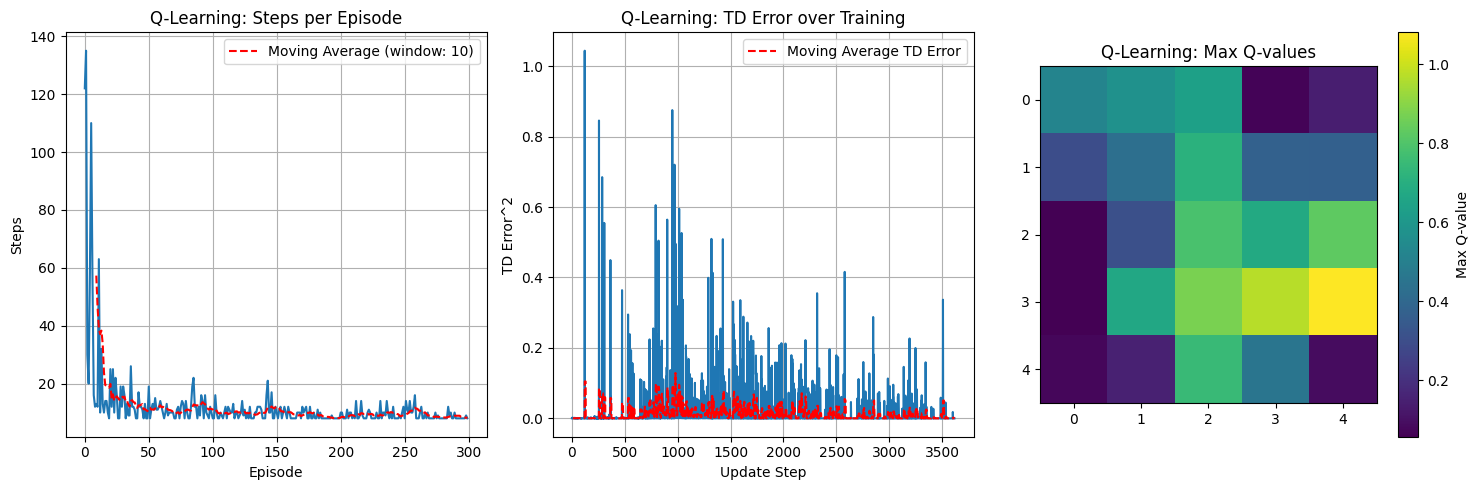


Final Learned Policy (Q-Learning):
→ → ↓ → ↓
↑ ↑ ↓ ↓ ↓
→ ↓ ↓ ← ↓
↑ → → → ↓
→ → ↑ ← G

Agent Movement Simulation with Q-Learning Policy:
S . . . . 
. . . . . 
. . . . . 
. . . . . 
. . . . G 

Step 1: Action=right, Reward=0.0
S A . . . 
. . . . . 
. . . . . 
. . . . . 
. . . . G 

Step 2: Action=right, Reward=0.0
S X A . . 
. . . . . 
. . . . . 
. . . . . 
. . . . G 

Step 3: Action=down, Reward=0.0
S X X . . 
. . A . . 
. . . . . 
. . . . . 
. . . . G 

Step 4: Action=down, Reward=0.0
S X X . . 
. . X . . 
. . A . . 
. . . . . 
. . . . G 

Step 5: Action=down, Reward=0.0
S X X . . 
. . X . . 
. . X . . 
. . A . . 
. . . . G 

Step 6: Action=right, Reward=0.0
S X X . . 
. . X . . 
. . X . . 
. . X A . 
. . . . G 

Step 7: Action=right, Reward=0.0
S X X . . 
. . X . . 
. . X . . 
. . X X A 
. . . . G 

Step 8: Action=down, Reward=1
S X X . . 
. . X . . 
. . X . . 
. . X X X 
. . . . G 

Goal reached! Total steps: 8


In [24]:
# Q-learning 메인 실행 코드
def main_q_learning():
    # 환경 초기화
    env = MyGridWorldEnvironment(start_point=(0,0), 
                               end_point=(4,4), 
                               grid_world_size=(5,5))
    
    # Q-Learning 에이전트 초기화
    agent = QLearning(env, learning_rate=0.1, discount_factor=0.9, epsilon=0.3)
    
    # 학습 시작
    print("Starting Q-Learning...")
    step_counts, losses = agent.train(num_episodes=300, max_steps=150)
    print("Learning completed!")
    
    # 학습 곡선 시각화
    plt.figure(figsize=(15, 5))
    
    # 단계 수 그래프
    plt.subplot(1, 3, 1)
    plt.plot(step_counts)
    plt.xlabel('Episode')
    plt.ylabel('Steps')
    plt.title('Q-Learning: Steps per Episode')
    plt.grid(True)
    
    # 이동 평균선
    window_size = 10
    if len(step_counts) > window_size:
        moving_avg = np.convolve(step_counts, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(step_counts)), moving_avg, 'r--', 
                 label=f'Moving Average (window: {window_size})')
        plt.legend()
    
    # 손실 그래프
    plt.subplot(1, 3, 2)
    plt.plot(losses)
    plt.xlabel('Update Step')
    plt.ylabel('TD Error^2')
    plt.title('Q-Learning: TD Error over Training')
    plt.grid(True)
    
    # 이동 평균 손실
    if len(losses) > window_size:
        loss_avg = np.convolve(losses, np.ones(window_size)/window_size, mode='valid')
        plt.plot(range(window_size-1, len(losses)), loss_avg, 'r--', 
                label=f'Moving Average TD Error')
        plt.legend()
    
    # Q-값 시각화
    plt.subplot(1, 3, 3)
    # 그리드 월드의 각 위치에서 최대 Q-값 계산
    q_values = np.zeros((env.height, env.width))
    for i in range(env.height):
        for j in range(env.width):
            q_values[i, j] = np.max(agent.q_table[i, j])
    
    # 히트맵으로 표시
    plt.imshow(q_values, cmap='viridis')
    plt.colorbar(label='Max Q-value')
    plt.title('Q-Learning: Max Q-values')
    plt.tight_layout()
    plt.show()
    
    # 최종 학습된 정책 출력
    print("\nFinal Learned Policy (Q-Learning):")
    action_symbols = {0: "↑", 1: "↓", 2: "←", 3: "→"}
    for i in range(env.height):
        policy_row = []
        for j in range(env.width):
            if (i, j) == env.end_point:
                policy_row.append("G")
            else:
                best_action = np.argmax(agent.q_table[i, j])
                policy_row.append(action_symbols[best_action])
        print(" ".join(policy_row))
    
    # 학습된 정책으로 테스트 실행
    print("\nAgent Movement Simulation with Q-Learning Policy:")
    state = env.reset()
    env.render()
    
    steps = 0
    max_steps = 30
    
    while state != env.end_point and steps < max_steps:
        # 탐험 없이 최적 정책만 따름
        action = np.argmax(agent.q_table[state[0], state[1]])
        next_state, reward = env.move(action)
        
        print(f"Step {steps+1}: Action={env.action_space[action]}, Reward={reward}")
        env.render()
        time.sleep(0.5)  # 시각화를 위한 일시 정지
        
        state = next_state
        steps += 1
    
    # 결과 출력
    if state == env.end_point:
        print(f"Goal reached! Total steps: {steps}")
    else:
        print("Maximum steps reached.")

if __name__ == "__main__":
    main_q_learning()